# Bootstrapping to estimate parameter ranges of nonlinear models

When we first introduced ourselves to regression, we focused the regression algorithm’s ability to find the “truth”, i.e. how close to the true parameter values does the algorithm get.

In statistics and boostrapping, the truth is (typically) unknown and there is noise associated with any given measurement. So our question becomes “how confident am I that the parameters of my model are not zero?” And as discussed in class, all kinds of challenges arise when using bootstrapping. Here, we'll try a simple example.

Let's consider one of our equations for bacterial growth:
\begin{align}
\dot{y} = \frac{y^3}{a+y^3}-by
\end{align}

where y is the concentration of bacterium and a and b are parameters that help define the rate of bacterial growth and loss, respectively. 

You have been provided with data, called "Homework11 Data.csv". Use this data for the following excercises. In this file, you'll find the time points sampled and the concentration of bacterium (y) for 5 independent experiments. We will consider data to be independent across time and experiments.

## Part 1: Plot data and perform initial fitting

In the space below, load the data and write the code to fit the parameters of our model to the data using minimize or fsolve. You may want to revisit your previous homeworks. To make things a little easier, I'll give you the first guess for your parameter. Go with (a,b) = (0.3,0.8). After fitting:
   - clearly indicate what were the parameter values and the value of the cost function you implemented.
   - Plot on one plot the data and the fitted model's response

   Time   Exp1   Exp2   Exp3   Exp4   Exp5
0    10   6.20   4.07   8.13   7.97   7.07
1    20   8.84   5.63  10.90  10.90   9.80
2    30   9.99   9.16  11.00   8.80  10.30
3    50  10.80  11.70  10.40  10.60   8.65


<AxesSubplot:xlabel='Time', ylabel='Conc Average'>

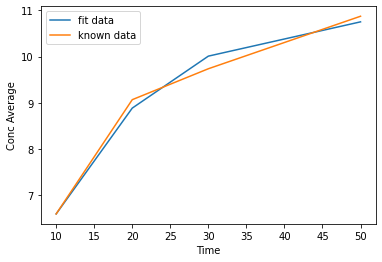

In [7]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt

tvalues = [10, 20, 30, 50]
averages = []

#lets teach a computer to read
dat = pd.read_csv(r"C:\Users\mdsnb\OneDrive\Documents\GitHub\ChE_2410_Math\Homework\Homework 6 Data.csv")

#what does the data look like
print(dat)

#making array with averages of experiments
for k in range(len(dat.index)):
    averages.append(dat.iloc[k, 1:5].mean())

#making dataframe of averaged data and column vector for later
data = pd.DataFrame({'Time':tvalues, 'Conc average':averages})
tempavgs = np.array(averages)
averagescolumn = tempavgs.reshape((4, 1))

#establish time values, initial conditions, and known parameters
tvalues = [10, 20, 30, 50]
ic = (dat.iloc[0, 1:5].mean(), 0.3, 0.8)

#ODE system definition
def sys(y, t, a, b):
    dy = (y**3)/(a + y**3)-b*y
    return(dy)

#error values
def error(params):
    a, b = params
    ODEoutput = odeint(sys, y0 = ic[0], t = tvalues, args = (a, b))
    #print('averagescolumn', averagescolumn,'ODEoutput[:,]',ODEoutput[:,])
    err = (averagescolumn - ODEoutput[:,])**2
    return np.sum(err)

#minimizing error function
sol = minimize(error, x0 = (ic[1], ic[2]))
#print('solution is', sol)
fitdata = np.ravel(np.array(odeint(sys, ic[0], tvalues, args=(sol.x[0], sol.x[1]))), order = 'C')
#print(fitdata)
fdat = pd.DataFrame({'Time':tvalues, 'Conc average':fitdata})
#print(fdat)

ax = fdat.plot(x = 'Time', y = 'Conc average', label = 'fit data', xlabel = 'Time', ylabel = 'Conc Average')
data.plot(x = 'Time', y = 'Conc average', label = 'known data', ax = ax)

## Part 2: Use sampling with replacement to create distributions of parameters that fit the data

Our hypothesis is that both a and b are greater than 0. Use the bootstrap method to create distributions of estimates of our parameter values. We can do this by, **for each iteration:**
   - Resample the data at each time point using sample with replacement (search online how to do).
   - Use minimize to refit the model to the resampled data
   - Save the fitted parameter estimates and the value of the cost function.
   
Do this for at least 200 iterations. HINT: this code may take a long time to run. It would be best to get the code working with only a few iterations. And once happy, then try 200. After completing, plot histograms of the fitted parameter values and cost function values. Figures must be clearly labeled and obvious to read. 

Based on these data, what is the p value for the null hypothesis that a and b are equal to zero? Calculate the one sided p value, based on the idea that we expect them to be greater than zero.
   

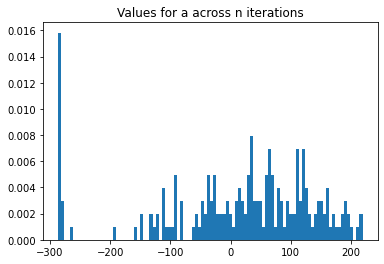

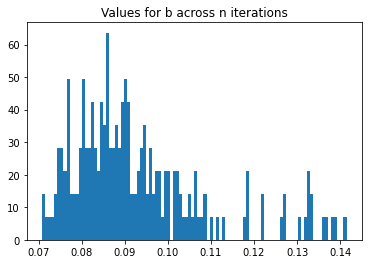

p value for both a and b being >= 0: 0.62 so we know both of them are not under 0, but the p value for a being >= 0: 0.62 meaning the likelihood of a being less than 0 is fairly high


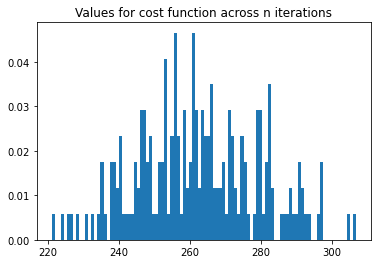

In [8]:
#stuff needed
iterations = 200
bins = 100
tally = 0
atally = 0
avgs = []
avals = []
bvals = []
cfvals = []

#starting to iterate sampling and producing parameter values
for k in range(iterations):

    #sampling across rows to make new dataframes to minimize parameter values from
    for j in range(len(dat.index)):
        sample = dat.iloc[j, 1:5].sample(n = 5, replace = True).values
        #print(sample)

        #keeping track of the averages
        avgs.append(np.mean(np.array(sample)))
    
    #print(avgs)

    #error function
    def error2(params):
        a, b = params
        ODEoutput = odeint(sys, y0 = ic[0], t = tvalues, args = (a, b))
        err = (avgs - ODEoutput[:,].T)**2
        return np.sum(err)
   
    #minimizing
    sol2 = minimize(error2, x0 = (ic[1], ic[2]))
    #print(sol2)

    #recording parameter and cost function values, then clearing for the next iteration
    avals.append(sol2.x[0])
    bvals.append(sol2.x[1])
    cfvals.append(error2([ic[1], ic[2]]))
    avgs = []

#print(avals)

#plotting
plt.hist(avals, density = True, bins = bins)
plt.title('Values for a across n iterations')
plt.show()
plt.hist(bvals, density = True, bins = bins)
plt.title('Values for b across n iterations')
plt.show()
plt.hist(cfvals, density = True, bins = bins)
plt.title('Values for cost function across n iterations')

#p value testing
for l in range(len(avals)):
    if avals[l] >= 0:
        if bvals[l] >= 0:
            tally = tally + 1
        atally = atally +1
pvalue = tally/iterations
pvaluea = atally/iterations

print('the p value for a being >= 0:',pvaluea,'meaning we do not know that a is greater than 0. Similarly, the p value for both a and be being >=0 is:', pvalue,'meaning we do not know both are greater than 0')

## Part 3 Analyze fit results

One a single figure, plot the model's response vs time for all 200 estimates of the parameter values. Are the fits reasonable? Should any of the fits be discounted? Why so? Does this change how you define your p values above? **Defend your answer here and include any plots as necessary:**



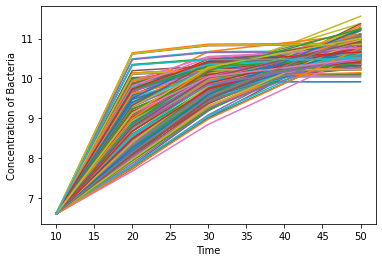

In [9]:
for k in range(len(avals)):
    tempa = avals[k]
    tempb = bvals[k]
    temparray = odeint(sys, y0 = ic[0], t = tvalues, args = (tempa, tempb))
    plt.plot([10, 20, 30, 50], temparray)

plt.xlabel('Time')
plt.ylabel('Concentration of Bacteria')
plt.show()

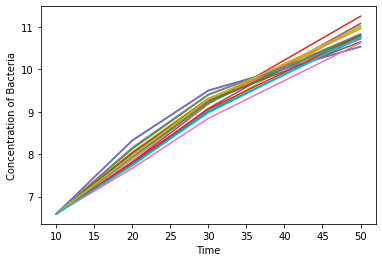

Average a value 169.7308904263657 average b value 0.0768552719335736


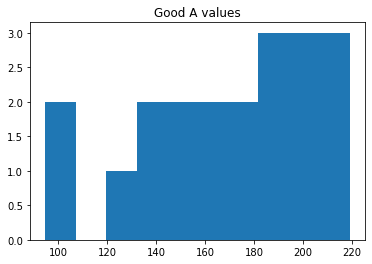

new p value for this filtered set is: 1.0


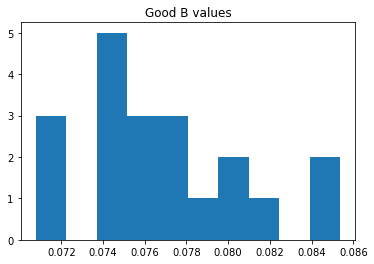

In [10]:
goodas = []
goodbs = []

for k in range(len(avals)):
    if cfvals[k] < 240:
        tempa = avals[k]
        tempb = bvals[k]
        goodas.append(tempa)
        goodbs.append(tempb)
        temparray = odeint(sys, y0 = ic[0], t = tvalues, args = (tempa, tempb))
        plt.plot([10, 20, 30, 50], temparray)

plt.xlabel('Time')
plt.ylabel('Concentration of Bacteria')
plt.show()

print('Average a value', np.average(goodas), 'average b value', np.average(goodbs))

plt.hist(goodas)
plt.title('Good A values')
plt.show()
plt.hist(goodbs)
plt.title('Good B values')

newtally = 0
for k in range(len(goodas)):
    if goodas[k] >= 0:
        if goodbs[k] >= 0:
            newtally = newtally + 1

newpvalue = newtally/len(goodas)

print('new p value for this filtered set is:', newpvalue)

Once cost functions of the iterations were limited to a specific set (low cost function values), the corresponding a and b values show a remarkably different distribution. Now we can see that the values of the parameters are almost certainly positive, and have the above p value for the odds of these parameters both being greater than 0, which indicates the null hypothesis of them being not greater than 0 is unlikely.

PROJECT INFORMATION

I want to analyze the relationship between use of public transportation and covid cases. I hypothesize that there will be a small but noticeable increase of cases for counties with high public transportation relative to density. That is to say, I will be trying to isolate the relationship between public transportation usage and covid cases, while controlling for obvious factors that would interfere, like population density and possibly household income.

My project is at the point of data organization. I have sets of data for all covid cases in 2021, public transportation usage in the 2019-2020 period by county, and county population densities from I believe the same 2019-2020 range. I am currently trying to turn the NYT county data into sum infections for 2021, which is a bit trickier than I anticipated.